In [1]:
from lbmpy.session import *
from lbmpy.phasefield.phasefieldstep_direct import PhaseFieldStepDirect
from lbmpy.phasefield.n_phase_boyer import *

from lbmpy.phasefield.contact_angle_circle_fitting import liquid_lens_neumann_angles
from pystencils.fd import Diff

one = sp.sympify(1)

import pyximport
pyximport.install(language_level=3)
from lbmpy.phasefield.simplex_projection import simplex_projection_2d  # NOQA

# Test of phase field with 4th order FD

### Free energy definition:

In [2]:
n = 3
domain_size = (150, 150)

ε = one * 4
penalty_factor = 0.01
stabilization_factor = 10

#κ = (one,  one/2, one/3, one/4)
κ = (one, one, one, one)
sigma_factor = one / 4 * 67 * 100
σ = sp.ImmutableDenseMatrix(n, n, lambda i,j: sigma_factor* (κ[i] + κ[j]) if i != j else 0 )
c = sp.symbols("c_:{}".format(n))

In [3]:
α, _ = diffusion_coefficients(σ)

f = lambda c: c**2 * ( 1 - c ) **2
a, b = compute_ab(f)

capital_f = capital_f0(c, σ) + correction_g(c, σ) + stabilization_factor * stabilization_term(c, α)

f_bulk = free_energy_bulk(capital_f, b, ε) 
f_if = free_energy_interfacial(c, σ, a, ε)
free_energy = (f_bulk + f_if) / 20000 / 100 + penalty_factor * (one - sum(c))**2

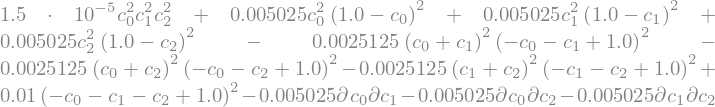

In [4]:
free_energy.evalf()

### Simulation:

In [5]:
step = PhaseFieldStepDirect(free_energy, c, domain_size)

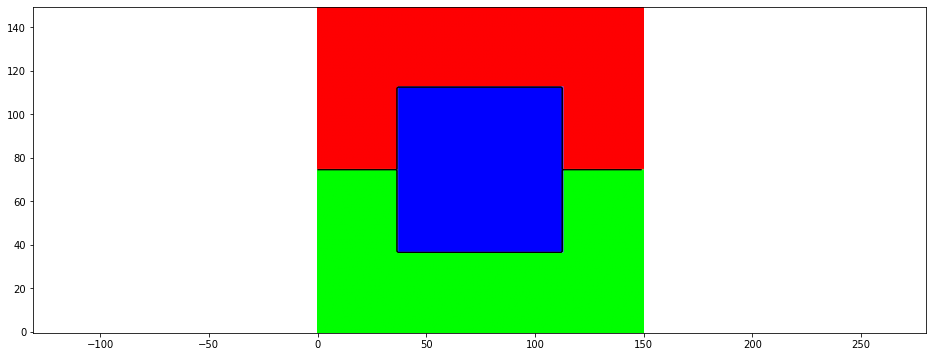

In [6]:
# geometric setup
step.set_concentration(make_slice[:, :], [0, 0, 0])
step.set_single_concentration(make_slice[:, :], phase_idx=0)
step.set_single_concentration(make_slice[:, :0.5], phase_idx=1)
step.set_single_concentration(make_slice[0.25:0.75, 0.25:0.75], phase_idx=2)
#step.smooth(4)
step.set_pdf_fields_from_macroscopic_values()

plt.phase_plot(step.phi[:, :])

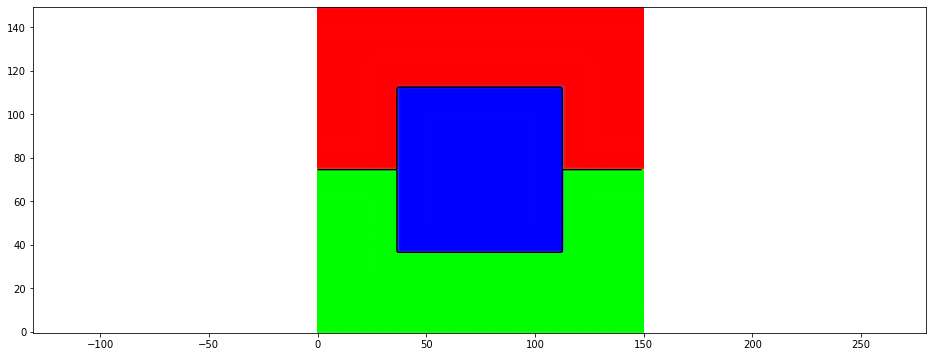

In [7]:
for i in range(10):
    step.time_step()
    #simplex_projection_2d(step.data_handling.cpu_arrays[step.phi_field.name])
plt.phase_plot(step.phi[:, :])

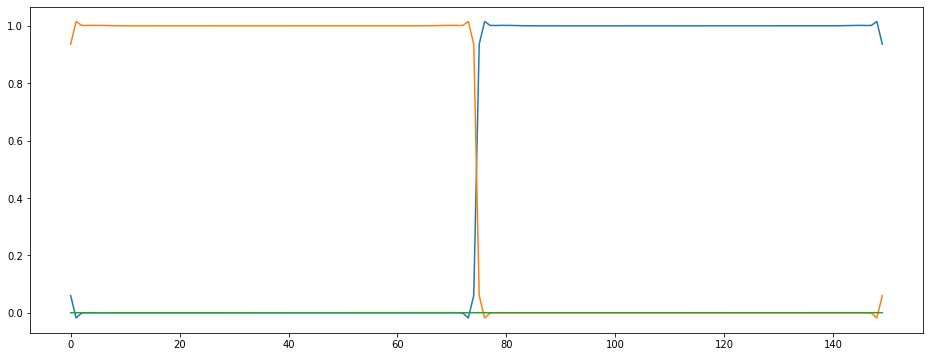

In [8]:
plt.plot(step.phi[25, :])

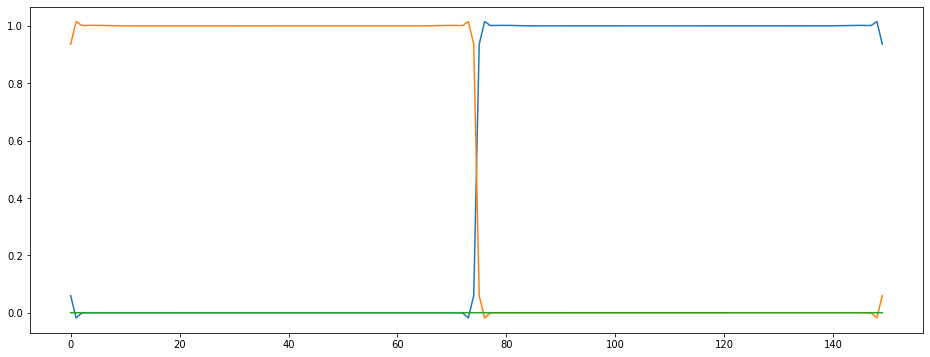

In [9]:
plt.plot(step.phi[15, :])